## Resample - initial test, runs on cdt laptop
Stage 2 of preprocessing, resample the images according to the procedure followed in the gp.

resampling controls the voxel size of images prior to training... this is interesting, im kinda confused as to how that is not the same as resizing the image, I will get into this later though.

UPDATE: See the engineering dissertation guy for an explanation of the resampling process.

In [39]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# resamples an image
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)

In [41]:
source_folder = "/media/benp/NVMEspare/datasets/MRI_IP_project/WMH_challenge_dataset/public/Singapore/50/"
bet_folder = "/media/benp/NVMEspare/datasets/preprocessing_attempts/wmh/singapore/50/"
bet_pre = bet_folder + "pre/"
bet_orig = bet_folder + "orig/"
source_pre = source_folder + "pre/"
source_orig = source_folder + "orig/"
folder_map = {"source/pre":source_pre, "source/orig":source_orig, "bet/pre":bet_pre, "bet/orig":bet_orig}

In [42]:
# load an image and a label to work with:
itk_image_flair = sitk.ReadImage(bet_orig + "FLAIR.nii.gz")
itk_image_t1 = sitk.ReadImage(bet_orig + "T1.nii.gz")
itk_label = sitk.ReadImage(source_folder + "wmh.nii.gz")

In [43]:
resampled_sitk_img_flair = resample_img(itk_image_flair, out_spacing=[1., 1., 3.])
resampled_sitk_img_t1 = resample_img(itk_image_t1, out_spacing=[1., 1., 3.])
resampled_sitk_label = resample_img(itk_label, out_spacing=[1., 1., 3.], is_label=True)

In [44]:
# check the before and after sizes
print(f"before: flair img size: {itk_image_flair.GetSize()}"
      f" t1 img size: {itk_image_t1.GetSize()}"
      f" label size: {itk_label.GetSize()}"
      f"\nafter:  flair img size: {resampled_sitk_img_flair.GetSize()}"
      f" t1 img size: {resampled_sitk_img_t1.GetSize()}"
      f" label size: {resampled_sitk_label.GetSize()}"
)

before: flair img size: (256, 232, 48) t1 img size: (256, 232, 48) label size: (256, 232, 48)
after:  flair img size: (256, 232, 48) t1 img size: (256, 232, 48) label size: (256, 232, 48)


In [50]:
x = sitk.GetArrayFromImage(resampled_sitk_img_flair)

In [52]:
x.shape

(48, 232, 256)

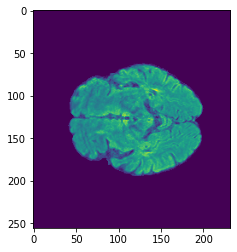

In [53]:
plt.imshow(x.T[:,:,20])

In [37]:
# saving those files to disk
def save_file(filepath, image):
    writer = sitk.ImageFileWriter()
    writer.SetFileName(filepath)
    writer.Execute(image)

In [38]:
save_folder = bet_folder
save_file(save_folder + "FLAIR_resampled.nii.gz", resampled_sitk_img_flair)
save_file(save_folder + "T1_resampled.nii.gz", resampled_sitk_img_t1)
save_file(save_folder + "wmh_resampled.nii.gz", resampled_sitk_label)